### Autoencoders with FASHION_MNIST

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, mse

(x_train, y_trainclass), (x_test, y_testclass) = fashion_mnist.load_data()

2024-05-19 21:11:41.690093: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 21:11:42.577155: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[ 8861 56959 41302  4129  4999]


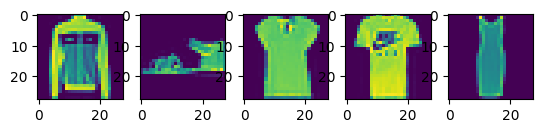

In [4]:
def plotn(n, x):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(x[0:n]):
        ax[i].imshow(z.reshape(28,28) if z.size==28*28 else z.reshape(14,14) if z.size==14*14 else z)
    plt.show()
    
def plotidx(indices, x):
    fig, ax = plt.subplots(1, len(indices))
    for i, z in enumerate(x[indices]):
        ax[i].imshow(z.reshape(28,28) if z.size==28*28 else z.reshape(14,14) if z.size==14*14 else z)
    plt.show()

ids = np.random.randint(len(x_train), size=5)
print(ids)
plotidx(ids,x_train)

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Denoising

In [6]:
input_img = Input(shape=(28,28,1))

# 28, 28, 16
x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
# 14, 14, 16
x = MaxPooling2D((2,2), padding='same')(x)
# 14, 14, 16 
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
# 7, 7, 64 
x = MaxPooling2D((2,2), padding='same')(x)
# 7, 7, 16
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
# 4, 4, 16
encoded = MaxPooling2D((2,2), padding='same')(x)

encoder = Model(input_img, encoded)

input_rep = Input(shape=(4,4,16))

x = Conv2D(16, (3,3), activation='relu', padding='same')(input_rep)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

decoder = Model(input_rep, decoded)

autoencoder_denoise = Model(input_img, decoder(encoder(input_img)))
autoencoder_denoise.compile(optimizer='adam', loss='binary_crossentropy')

2024-05-19 21:11:44.217514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 748 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


[42765 31127 45833 47606 10726]
before adding noises


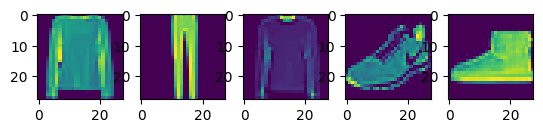

after adding noises


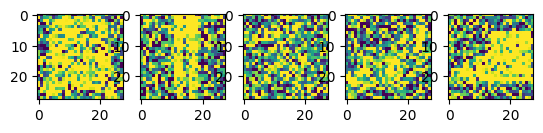

In [7]:
def noisify(data):
  return np.clip(data+np.random.normal(loc=0.5,scale=0.5,size=data.shape),0.,1.)


x_train_noise = noisify(x_train)
x_test_noise = noisify(x_test)

ids = np.random.randint(len(x_train_noise), size=5)
print(ids)

print("before adding noises")
plotidx(ids,x_train)
print("after adding noises")
plotidx(ids,x_train_noise)

In [8]:
autoencoder_denoise.fit(x_train_noise, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noise, x_test))

Epoch 1/25


I0000 00:00:1716127908.187565  129548 service.cc:145] XLA service 0x7dae8000d300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716127908.187594  129548 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-05-19 21:11:48.235303: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-19 21:11:48.483058: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 32/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6446

I0000 00:00:1716127910.483157  129548 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.4429 - val_loss: 0.3370
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3320 - val_loss: 0.3269
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3249 - val_loss: 0.3251
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3197 - val_loss: 0.3205
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3172 - val_loss: 0.3174
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3149 - val_loss: 0.3167
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3134 - val_loss: 0.3144
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3117 - val_loss: 0.3124
Epoch 9/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3103 - val_loss: 0.3115
Epoch 10/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3088 - val_loss: 0.3100
Epoch 11/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3085 - val_loss: 0.3097
Epoch 12/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 

[6238 6354 9017 7361 3809]
input


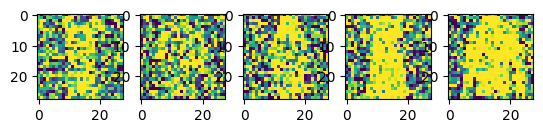

prediction


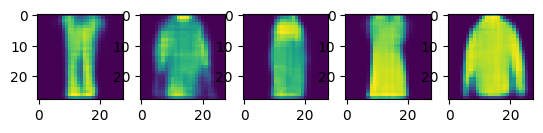

label


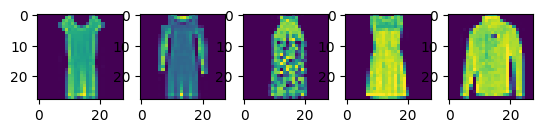

In [10]:
ids = np.random.randint(len(x_test_noise), size=5)
print(ids)
y_test = autoencoder_denoise.predict(x_test_noise[ids], verbose=False)
print("input")
plotidx(ids, x_test_noise)
print("prediction")
plotn(5, y_test)
print("label")
plotidx(ids, x_test)

# Super-resolution

[19740 14256 30485 59713   687]
before downsample


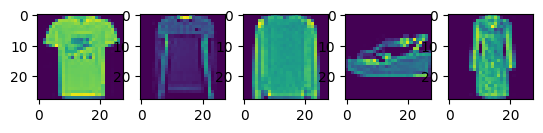

after downsample


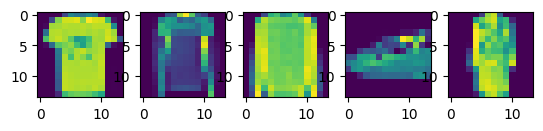

In [11]:
x_train_lr = tf.keras.layers.AveragePooling2D(2)(x_train).numpy()
x_test_lr = tf.keras.layers.AveragePooling2D(2)(x_test).numpy()

ids = np.random.randint(len(x_train), size=5)
print(ids)
print("before downsample")
plotidx(ids, x_train)
print("after downsample")
plotidx(ids, x_train_lr)

In [12]:
input_img = Input(shape=(14, 14, 1))

x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

encoder = Model(input_img, encoded)

input_rep = Input(shape=(4,4,16))

x = Conv2D(16, (3,3), activation='relu', padding='same')(input_rep)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

decoder = Model(input_rep, decoded)

autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [13]:
autoencoder.fit(x_train_lr, x_train,
               epochs=25,
               batch_size=128,
               shuffle=True,
               validation_data=(x_test_lr, x_test))

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.4073 - val_loss: 0.3037
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2976 - val_loss: 0.2949
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2917 - val_loss: 0.2910
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2887 - val_loss: 0.2881
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2850 - val_loss: 0.2864
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2833 - val_loss: 0.2853
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2825 - val_loss: 0.2845
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2819 - val_loss: 0.2830
Epoch 9/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2814 - val_loss: 0.2826
Epoch 10/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2803 - val_loss: 0.2816
Epoch 11/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2801 - val_loss: 0.2812
Epoch 12/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

[4123 9697 7473 5907 2363]
input


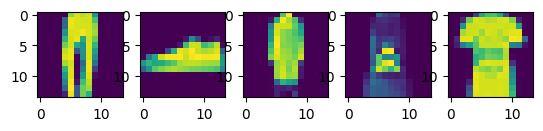

prediction


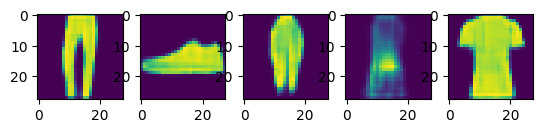

label


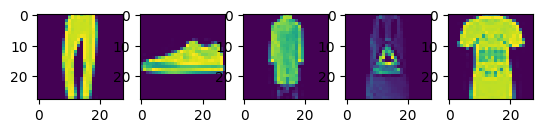

In [14]:
ids = np.random.randint(len(x_test_lr), size=5)
print(ids)
y_test_lr = autoencoder.predict(x_test_lr[ids], verbose=False)
print("input")
plotidx(ids, x_test_lr)
print("prediction")
plotn(5, y_test_lr)
print("label")
plotidx(ids, x_test)